# Machine Learning with TensorFlow

#### Project Name: Classification of Diabetic Retinopathy


In [26]:
import numpy as np
import scipy as sp
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import os
from PIL import Image
import cv2
import glob
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model, datasets, layers, models
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [27]:
print(tf.__version__)

2.0.0


# Evaluation and processing image data set 

#### Mask and filtering to remove boundaries

In [4]:
# Image Processing Section
# Color filtering 
# Add a mask to remove boundaries

def crop_from_gray(image, threshold): 
    
    if image.ndim ==2:
        mask = image>threshold
        return image[np.ix_(mask.any(1),mask.any(0))]

    elif image.ndim ==3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = gray_image>threshold
        
        check_shape = image[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return image # return original image
        else:
            img1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            image = np.stack([img1,img2,img3],axis=-1)
        return image

#### Circle crop to make images uniform

In [7]:
def circle_crop(img):
    """
    Create circular crop around image centre
    """
    img = crop_from_gray(img,7)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_from_gray(img,7)

    return img

In [8]:
# Define and initialize image processing parameters 
width = 100
height = 100
channel=3
sigmaX = 10
threshold = 7


# read image from a path

Image_path = 'train_imagesv2/*.png'
file_list = glob.glob(Image_path)

# image processing: color filtering, circle cropping, resizing, enhance contrast
raw_image=[]
processed_image=[]

for file in file_list:
    img = cv2.imread(file)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # change the image from 3 channel to 1   
    raw_image.append(img2)    
    img = circle_crop(img2)                           
    img = cv2.resize(img,(width,height))
    img = cv2.addWeighted (img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    processed_image.append(np.array(img))


## Evaluate pixel size of two sample images

In [79]:
print('shape of image #10:' , raw_image[10].shape)
print('shape of image #15:' , raw_image[15].shape)

shape of image #10: (2848, 4288, 3)
shape of image #15: (1050, 1050, 3)


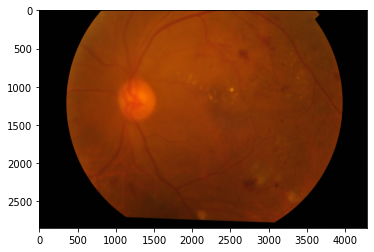

In [10]:
plt.imshow(raw_image[10])

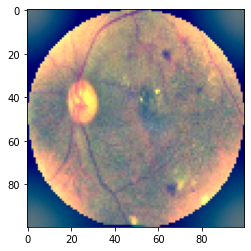

In [9]:
plt.imshow(processed_image[10])

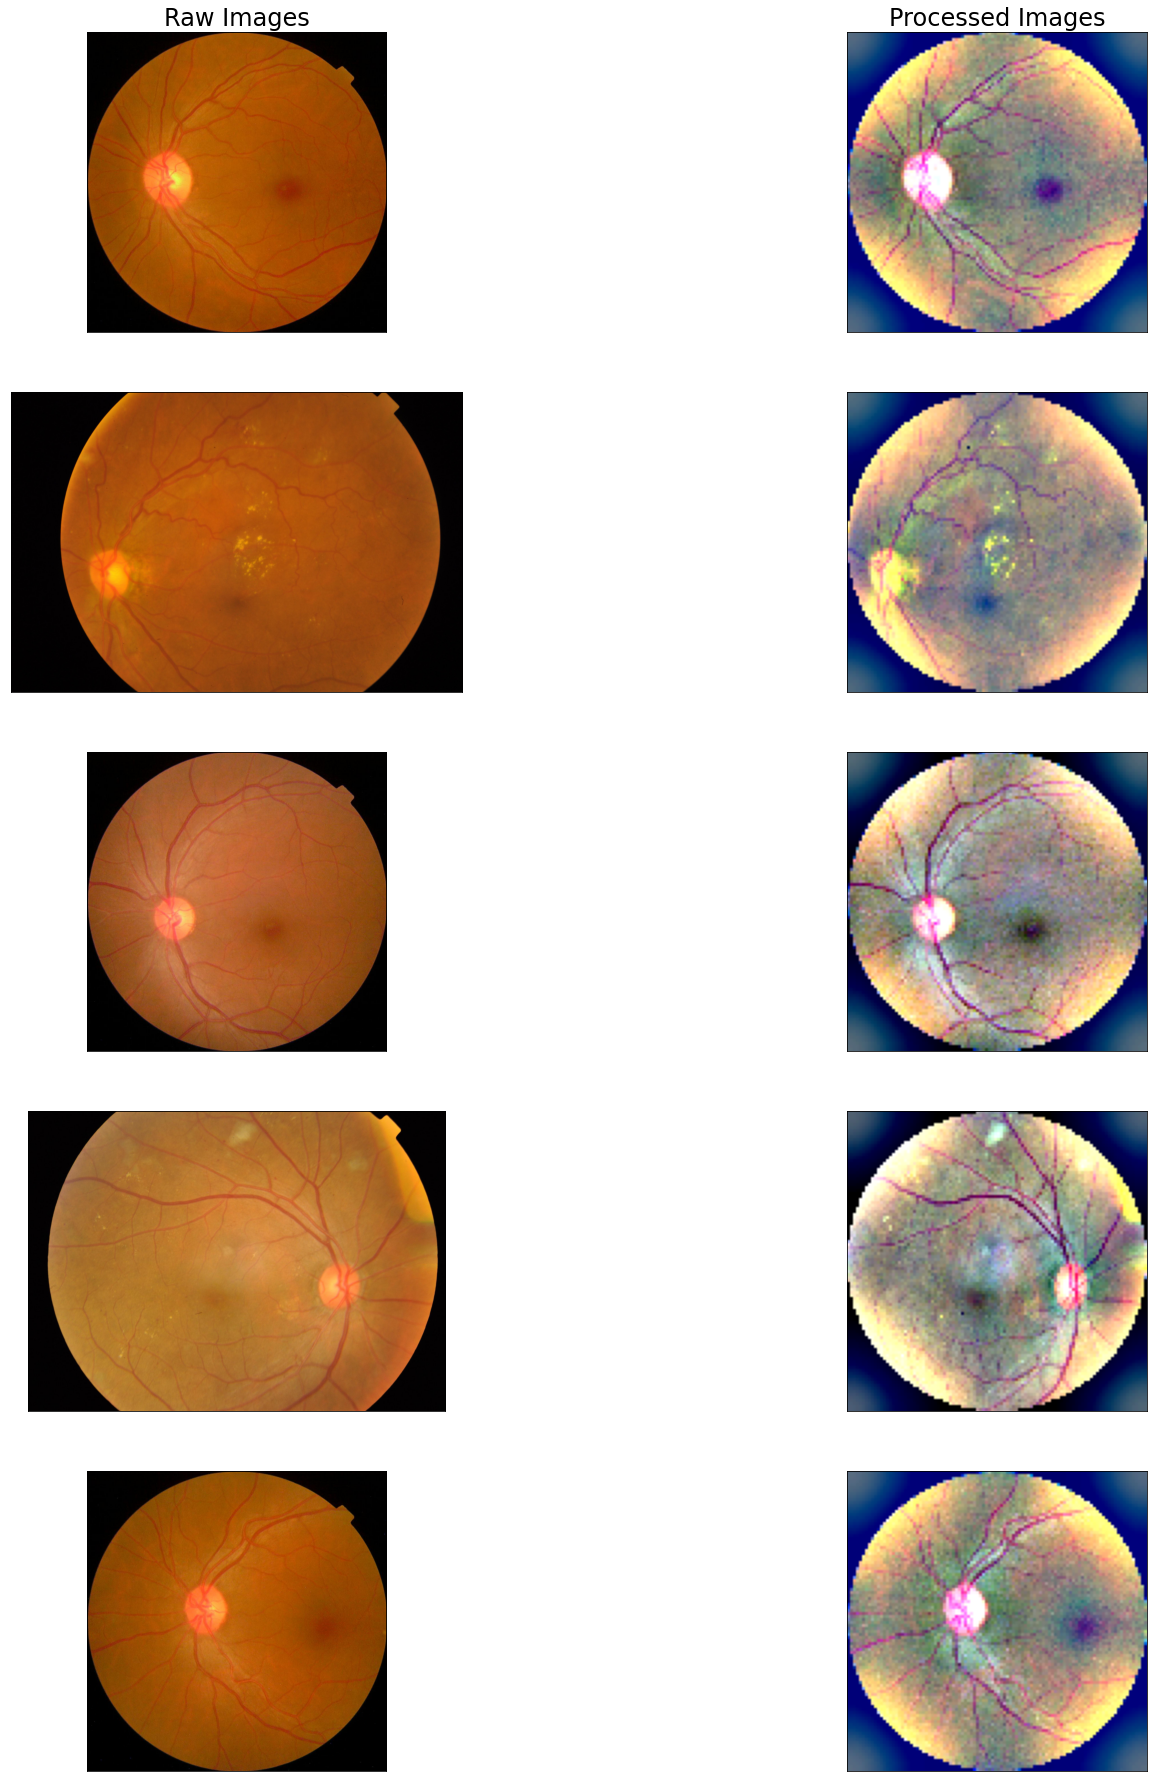

In [75]:
fig = plt.figure(figsize=(25, 32))

ax = fig.add_subplot(5, 2, 1 , xticks=[], yticks=[])
plt.imshow(raw_image[6])
ax.set_title('Raw Images' ,fontsize=24)
ax = fig.add_subplot(5, 2, 2 , xticks=[], yticks=[])
plt.imshow(processed_image[6])
ax.set_title('Processed Images',fontsize=24 )

ax = fig.add_subplot(5, 2, 3 , xticks=[], yticks=[])
plt.imshow(raw_image[3])
ax = fig.add_subplot(5, 2, 4 , xticks=[], yticks=[])
plt.imshow(processed_image[3])

ax = fig.add_subplot(5, 2, 5 , xticks=[], yticks=[])
plt.imshow(raw_image[1])
ax = fig.add_subplot(5, 2, 6 , xticks=[], yticks=[])
plt.imshow(processed_image[1])

ax = fig.add_subplot(5, 2, 7 , xticks=[], yticks=[])
plt.imshow(raw_image[7])
ax = fig.add_subplot(5, 2, 8 , xticks=[], yticks=[])
plt.imshow(processed_image[7])


ax = fig.add_subplot(5, 2, 9 , xticks=[], yticks=[])
plt.imshow(raw_image[8])
ax = fig.add_subplot(5, 2, 10 , xticks=[], yticks=[])
plt.imshow(processed_image[8])
        

Text(0.5, 1.0, '0 - No DR')

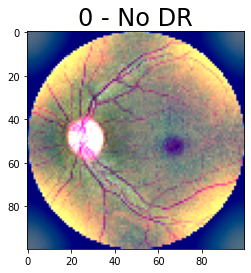

In [11]:
plt.imshow(processed_image[6],cmap='gray')
plt.title('0 - No DR', fontsize=24)

Text(0.5, 1.0, '1 - Mild')

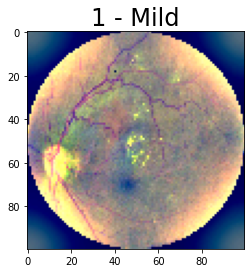

In [12]:
plt.imshow(processed_image[3],cmap='gray')
plt.title('1 - Mild', fontsize=24)

Text(0.5, 1.0, '2 - Moderate')

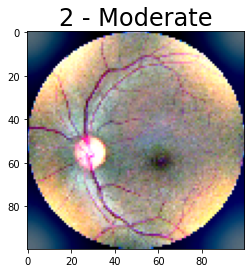

In [13]:
plt.imshow(processed_image[1],cmap='gray')
plt.title('2 - Moderate', fontsize=24)

Text(0.5, 1.0, '3 - Sever')

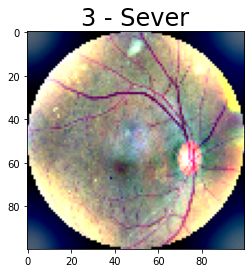

In [14]:
plt.imshow(processed_image[7],cmap='gray')
plt.title('3 - Sever', fontsize=24)

Text(0.5, 1.0, '4 - Proliferative DR')

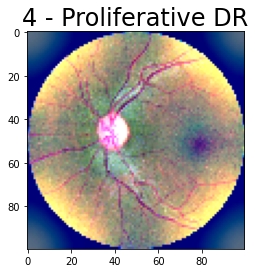

In [15]:
plt.imshow(processed_image[8],cmap='gray')
plt.title('4 - Proliferative DR', fontsize=24)

# Read Label data from csv file

In [17]:
label = pd.read_csv('train.csv')
label.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [18]:
# Clean file list name
file_list = list(map(lambda file_list: file_list.replace('train_imagesv2\\','').replace('.png',''),file_list))

In [19]:
ind=[]
ind_val=[]

for i in file_list:
    ind.append(label.id_code[label['id_code'] == i].index[0])
    
labels = label.diagnosis.iloc[ind]

# Convert to np array
processed_image = np.array(processed_image)
labels = np.array(labels)


In [20]:
# reshape image 
processed_image = processed_image.reshape(processed_image.shape[0],width,height,channel)

print(processed_image.shape)
print(labels.shape)


(978, 100, 100, 3)
(978,)


In [21]:
# LABELS: One-hot encoding 

labels = np.reshape(labels, (-1,1))

print(labels.shape)


unique_category_count = 5 
input_label = tf.one_hot(labels,unique_category_count )
input_label = np.squeeze(input_label,axis=1)


print(input_label)
print(input_label.shape)

(978, 1)
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
(978, 5)


# Create Train & Test Data Sets

In [22]:
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test = train_test_split(processed_image, input_label, test_size=0.15, random_state=4)

# Keras Model

In [30]:
# KERAS Model, Setup
Keras_model = models.Sequential()

  # Layer 1
Keras_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape = (width, height,channel))) # kernel
Keras_model.add(layers.MaxPooling2D((2, 2)))
  # Layer 2
Keras_model.add(layers.Conv2D(64, (3, 3)))
Keras_model.add(BatchNormalization())
Keras_model.add(Activation('relu'))
Keras_model.add(layers.MaxPooling2D((2, 2)))
  # Layer 3
Keras_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Keras_model.add(layers.MaxPooling2D((2, 2)))
Keras_model.add(Flatten())
  # Layer 4
Keras_model.add(Dense(128, input_dim=20, activation='relu'))
Keras_model.add(Dropout(0.5))
Keras_model.add(Dense(64, activation='relu'))
Keras_model.add(Dropout(0.5))
Keras_model.add(Dense(5, activation='softmax'))
Keras_model.compile(optimizer='adam',
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

In [34]:
# KERAS Model, Summary
print('Keras Model:')
Keras_model.summary()

Keras Model:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 2

In [35]:
print('train image shape: ',image_train.shape)
print('input label shape: ',label_train.shape)

train image shape:  (831, 100, 100, 3)
input label shape:  (831, 5)


In [36]:
print('validation image shape: ',image_test.shape)
print('output label shape: ',label_test.shape)

validation image shape:  (147, 100, 100, 3)
output label shape:  (147, 5)


In [38]:
# KERAS Model, Run
Keras_history = Keras_model.fit(image_train, label_train, batch_size= 32, epochs=30, validation_data=(image_test, label_test))

Train on 831 samples, validate on 147 samples
Epoch 1/30
831/831 [==============================] - 1s 708us/sample - loss: 0.2830 - accuracy: 0.8881 - val_loss: 1.5895 - val_accuracy: 0.5918
Epoch 2/30
831/831 [==============================] - 1s 690us/sample - loss: 0.2552 - accuracy: 0.9013 - val_loss: 1.4131 - val_accuracy: 0.5850
Epoch 3/30
831/831 [==============================] - 1s 679us/sample - loss: 0.2302 - accuracy: 0.9182 - val_loss: 1.3937 - val_accuracy: 0.6122
Epoch 4/30
831/831 [==============================] - 1s 684us/sample - loss: 0.2252 - accuracy: 0.9158 - val_loss: 1.5682 - val_accuracy: 0.6259
Epoch 5/30
831/831 [==============================] - 1s 684us/sample - loss: 0.2236 - accuracy: 0.9194 - val_loss: 1.5132 - val_accuracy: 0.5986
Epoch 6/30
831/831 [==============================] - 1s 688us/sample - loss: 0.2649 - accuracy: 0.8977 - val_loss: 1.9933 - val_accuracy: 0.4626
Epoch 7/30
831/831 [==============================] - 1s 683us/sample - loss: 

In [39]:
Keras_history_dict = Keras_history.history
print(Keras_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


147/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

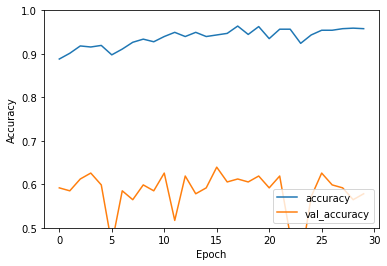

In [40]:
# KERAS Model, Plot
plt.plot(Keras_history.history['accuracy'], label='accuracy')
plt.plot(Keras_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = Keras_model.evaluate(image_test,  label_test, verbose=1)
print("KERAS, test loss:", test_loss)

# Model DenseNet

In [43]:
densenet = DenseNet121(
    weights='DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(100,100,3)
)

In [44]:
def build_model():
    Dense_model = Sequential()
    Dense_model.add(densenet)
    Dense_model.add(layers.GlobalAveragePooling2D())
    Dense_model.add(layers.Dropout(0.5))
    Dense_model.add(layers.Dense(5, activation='sigmoid'))
    
    Dense_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return Dense_model

In [45]:
Dense_model = build_model()
Dense_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [46]:
Dense_history = Dense_model.fit(image_train, label_train, batch_size= 32, epochs=30, validation_data=(image_test, label_test))

Train on 831 samples, validate on 147 samples
Epoch 1/30
831/831 [==============================] - 38s 45ms/sample - loss: 0.8147 - accuracy: 0.6173 - val_loss: 1.1695 - val_accuracy: 0.5279
Epoch 2/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.5201 - accuracy: 0.7617 - val_loss: 0.8217 - val_accuracy: 0.5878
Epoch 3/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.3684 - accuracy: 0.8351 - val_loss: 0.6222 - val_accuracy: 0.6884
Epoch 4/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.2806 - accuracy: 0.8833 - val_loss: 0.4740 - val_accuracy: 0.7864
Epoch 5/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.2138 - accuracy: 0.9196 - val_loss: 0.3922 - val_accuracy: 0.8367
Epoch 6/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.1770 - accuracy: 0.9365 - val_loss: 0.3514 - val_accuracy: 0.8626
Epoch 7/30
831/831 [==============================] - 5s 6ms/sample - loss: 0.1447 - acc

In [48]:
Dense_history_dict = Dense_history.history
print(Dense_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


147/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

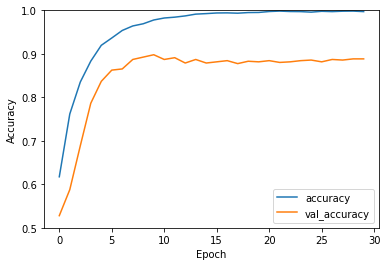

In [52]:
# DensNEt Model, Plot
plt.plot(Dense_history.history['accuracy'], label='accuracy')
plt.plot(Dense_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = Dense_model.evaluate(image_test,  label_test, verbose=1)
print("KERAS, test loss:", test_loss)